# Exploring Airbnb Prices in New York City
#### Aman Jaiman, Andrew Mao, Adam Howard
---

## Introduction
---

This winter, we're planning to take a trip to New York City! Everyone knows the cost of living there is sky-high, so we wanted to see if there was a way to find bargains.

Airbnb is a shared economy platform for people to offer their own housing for travellers. Since 2008, it has grown in popularity and has become ubiquitous in travelling options, becoming a large competitor in the hotel industry.

Pricing an Airbnb becomes challenging. You need to figure out your amenities, and how valuable they are compared to other offered amenities in the area. In a large metropolitan area, such as New York, homeowners need to be able to price their property at a competitve price to make a profit. In this tutorial, we look at Airbnb data from New York City and try to figure out if there are predictors for price.

## Data Collection
---
For this tutorial, we will be using 2019 [New York City Airbnb data](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data), published by dgomonov on Kaggle. This data includes information about the hosts, geographical data, and other potential predictors of price.

We'll be using Python 3 for this tutorial, along with the following libraries:
* [Numpy](https://docs.scipy.org/doc/numpy/user/)
* [Pandas](https://pandas.pydata.org/pandas-docs/stable/)
* [Scikit-Learn](http://scikit-learn.org/stable/documentation.html)
* [Seaborn](https://seaborn.pydata.org/)
* [Folium](https://github.com/python-visualization/folium)
* [Plotly](https://github.com/plotly/plotly.py)
* Matplotlib

In [6]:
import folium
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import folium # generating maps
from folium.plugins import MarkerCluster # marker clusters for map
from folium.plugins import MiniMap # minimap display for map
from IPython.display import HTML, display # displaying maps in the notebook
import seaborn as sns; sns.set() # graphing data

Let's take a look at what the data looks like. Open the `.csv` file in the kaggle folder

In [9]:
main_df = pd.read_csv('nyc.csv')
main_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Each entry gives us information about the property.
* The `name` of the property is set by the host
* `host_id` and `host_name` are identification ids of the host for Airbnb
* There are five groups in `neighbourhood_group`, shown above
* The `neighbourhood` tells us which specific neighbourhood in the group the property belongs to
* `latitude` and `longitude` give us the coordinates of the location. We can use this with folium to map all the locations
* `room_type` indicates the type of room the property is
* `price` will be the attribute we will try to predict
* `minimum_nights` are the minimum number of nights the property has to be booked for
* `number_of_reviews`, `last_review`, and `reviews_per_month` give us information about the reviews of each property. Unfortunately, we don't have the actual reviews or rating
* `calculated_host_listings_count` and `availability_365` are additional features that tell us how many total properties the host has, and how long this property is available in a year

Let's examine some basic stats:

There are close to 50k entries, so we want to sample data for plotting. Data seems to missing for some fields, most noticeably those relating to the number of reviews.

In [10]:
print(main_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

Let's examine the categorical variables. Questions: what kind of boroughs, neighborhoods, and room types do we have?

In [11]:
print("Neighbourhood Groups:", main_df['neighbourhood_group'].unique().tolist())
print("Room Types:", main_df['room_type'].unique().tolist())

Neighbourhood Groups: ['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']
Room Types: ['Private room', 'Entire home/apt', 'Shared room']


What are our outliers in terms of price? We find that there are some very large outliers, so for visualization purposes, we winsorize (ignore) the top 5% of data, about $400.

In [12]:
print(main_df['price'].describe(percentiles=[.25, .50, .75, .95]))

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
95%        355.000000
max      10000.000000
Name: price, dtype: float64


## Data Exploration
---
Now that we have seen the data that we are working with, let's visualize our data in order to get a better understanding of it.

We'll start by looking at some geographical data: 
* what boroughs have the most rooms?
* what is the price distribution of rooms per borough?
* what is the frequency and price distribution of rooms per room type?


#### Location (Neighbourhood and Neighbourhood Group)

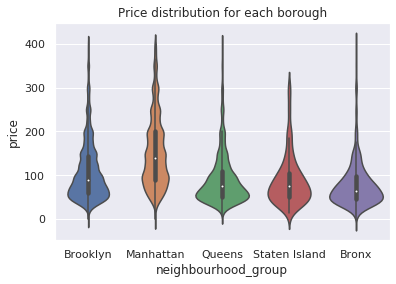

In [15]:
# ax = sns.scatterplot(x='neighbourhood_group', y='price', data=main_df, s=14)

#we can see from our statistical table that we have some extreme values, therefore we need to remove them for the sake of a better visualization

#creating a sub-dataframe with no extreme values / less than 500
winsorized_df=main_df[main_df.price < 400]
#using violinplot to showcase density and distribtuion of prices 
viz_2=sns.violinplot(data=winsorized_df, x='neighbourhood_group', y='price')
viz_2.set_title('Price distribution for each borough')
plt.show()

Here's the distribution of prices of properties, based on which neighbourhood group they belong to. We can see that Manhattan sems to have more of the higher priced properties. Bronx, Staten Island, and Queens have much more reasonable prices compared to Brooklyn and Manhattan. All distributions have positive skew.

Let's examine the frequency of listings, grouped by borough, and room type.

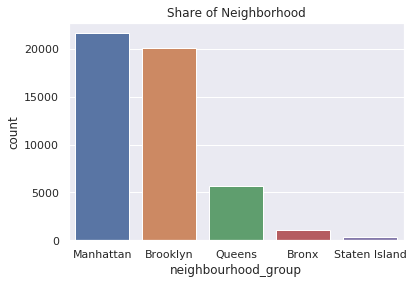

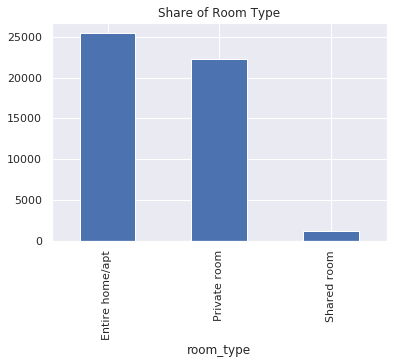

In [19]:
# f,ax=plt.subplots(1,2,figsize=(18,8))
# data['neighbourhood_group'].value_counts().plot.pie(explode=[0,0.1,0,0,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
# ax[0].set_title('Share of Neighborhood')
# ax[0].set_ylabel('Neighborhood Share')
ax = sns.countplot('neighbourhood_group',data=main_df,order=main_df['neighbourhood_group'].value_counts().index)
ax.set_title('Share of Neighborhood')
plt.show()

main_df.groupby('room_type').size().plot.bar()
plt.title("Share of Room Type")
plt.show()

We see that Manhattan and Brooklyn have the highest number of listings, at around 20K each. We also see that entire homes and private rooms are the most common.


Next, let's see what the properties look like on a map. We'll use folium to create a map centered around New York City. Because of issues with rendering the full dataset, we will randomly assign a value to each data point (between 0 and 1), and plot it on the map if the random value is less than .02, giving each data point a 2% random chance of being plotted.

First, let's create a color scale for the markers that will be shown on the map. If we want 5 increments in our color scale, we'll split the prices into 5 even chunks and assign a color for each chunk.

In [20]:
prices = sorted(main_df['price'].unique().tolist())
partition_length = len(prices)//5 # we want 5 increments for our color scale
current = 0
for i in range(5):
    print(prices[current:current+partition_length][-1])
    current += partition_length

144
278
430
805
7703


In [21]:
# Assigning colors to the partitions
def get_color(price):
    if price <= 144:
        return 'darkblue'
    elif price <= 278:
        return 'lightblue'
    elif price <= 430:
        return 'orange'
    elif price <= 805:
        return 'lightred'
    else:
        return 'red'

In [22]:
m = folium.Map(location=[40.71455, -74.00712], zoom_start=13) # Creating a folium map

#mc = MarkerCluster()
import random
for i,row in main_df.sample(1000).iterrows():
#     if random.random() < .015:
    name = row['name']
    neighbourhood_group = row['neighbourhood_group']
    neighborhood = row['neighbourhood']
    lat = row['latitude']
    long = row['longitude']
    room_type = row['room_type']
    price = row['price']
    min_nights = row['minimum_nights']
    c = get_color(price)

    folium.CircleMarker(location=[lat, long], 
                        color=c, 
                        radius=2,
                        popup=(str(name)+": $"+str(price))).add_to(m)

    #mc.add_child(folium.Marker(location=[lat, long], icon=folium.Icon(color=c), popup=(str(name)+": $"+str(price))))
minimap = MiniMap()
m.add_child(minimap)
display(m)

In [24]:
# Geographic plot using Plotly

import plotly.graph_objects as go

sample_df = winsorized_df.sample(1000)

# mapbox_access_token = open(".mapbox_token").read()
mapbox_access_token = "pk.eyJ1IjoibWFvc2VmIiwiYSI6ImNrMTNzYXY5dDBjcHIzbW51d2J1ZjJweHoifQ.CA3fec_PEoQHxf9jr7yGaA"

fig = go.Figure(go.Scattermapbox(
        lon = sample_df['longitude'],
        lat = sample_df['latitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=5,
            color = sample_df['price'],
            colorscale="RdBu",
            reversescale=True,
            colorbar=dict(
                title="Price ($)"
            ),
        ),
#         color_continuous_scale="IceFire",
#         text=['Montreal'],
    ))

fig.update_layout(
    title="Airbnb prices in New York City",
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=40.7,
            lon=-74
        ),
        pitch=0,
        zoom=8
    )
)

fig.show()

ModuleNotFoundError: No module named 'plotly'

We see there is definitely clustering of higher prices in downtown Manhattan. There are also noticeable clusters in Upper Brooklyn and Upper Manhattan. Location could provide a good signal of price.

Let's examine the text of the reviews, and plot the most common words.

In [12]:
#### Type of room
#### Popularity (Reviews per month)
#### NLP on Name

We look at a correlation plot among the numerical variables. We don't see any strong correlations between meaningful variables, except number_of_reviews vs reviews_per_month




In [13]:
main_df.corr().style.background_gradient(cmap='coolwarm')

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,1,0.58829,-0.00312529,0.0909085,0.0106187,-0.0132245,-0.31976,0.291828,0.133272,0.0854676
host_id,0.58829,1,0.0202242,0.127055,0.0153091,-0.0173643,-0.140106,0.296417,0.15495,0.203492
latitude,-0.00312529,0.0202242,1,0.0847884,0.0339387,0.0248693,-0.0153888,-0.0101416,0.0195174,-0.0109835
longitude,0.0909085,0.127055,0.0847884,1,-0.150019,-0.0627471,0.0590943,0.145948,-0.114713,0.0827307
price,0.0106187,0.0153091,0.0339387,-0.150019,1,0.0427993,-0.0479542,-0.0306083,0.0574717,0.0818288
minimum_nights,-0.0132245,-0.0173643,0.0248693,-0.0627471,0.0427993,1,-0.0801161,-0.121702,0.12796,0.144303
number_of_reviews,-0.31976,-0.140106,-0.0153888,0.0590943,-0.0479542,-0.0801161,1,0.549868,-0.0723761,0.172028
reviews_per_month,0.291828,0.296417,-0.0101416,0.145948,-0.0306083,-0.121702,0.549868,1,-0.00942116,0.185791
calculated_host_listings_count,0.133272,0.15495,0.0195174,-0.114713,0.0574717,0.12796,-0.0723761,-0.00942116,1,0.225701
availability_365,0.0854676,0.203492,-0.0109835,0.0827307,0.0818288,0.144303,0.172028,0.185791,0.225701,1


## Predicting Price

The problem is of regressing price.

Let's try a multiple linear regression on the features. We drop the features (name, id, host name, and last review). We transform the categorical variables (neighbourhood_group, neighbourhood, room_type) into labels using Scikit-Learn's label transformer. 

We use Ordinary Least Squares (OLS) Regression. We hold out 20% of the data for testing. 

In [14]:
'''Machine Learning'''
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor


# Preparing the main_df 
main_df.drop(['name','id','host_name','last_review'],axis=1,inplace=True)
main_df['reviews_per_month']=main_df['reviews_per_month'].replace(np.nan, 0)

'''Encode labels with value between 0 and n_classes-1.'''
le = preprocessing.LabelEncoder() # Fit label encoder
le.fit(main_df['neighbourhood_group'])
main_df['neighbourhood_group']=le.transform(main_df['neighbourhood_group']) # Transform labels to normalized encoding.

le = preprocessing.LabelEncoder()
le.fit(main_df['neighbourhood'])
main_df['neighbourhood']=le.transform(main_df['neighbourhood'])

le = preprocessing.LabelEncoder()
le.fit(main_df['room_type'])
main_df['room_type']=le.transform(main_df['room_type'])

main_df.sort_values(by='price',ascending=True,inplace=True)

main_df.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
25796,86327101,1,13,40.68258,-73.91284,1,0,1,95,4.35,6,222
25634,15787004,1,28,40.69467,-73.92433,1,0,2,16,0.71,5,0
25433,131697576,0,62,40.83296,-73.88668,1,0,2,55,2.56,4,127
25753,1641537,1,91,40.72462,-73.94072,1,0,2,12,0.53,2,0
23161,8993084,1,13,40.69023,-73.95428,1,0,4,1,0.05,4,28


In [15]:
'''Train LRM'''
lm = LinearRegression()

X = main_df[['neighbourhood_group','neighbourhood','latitude','longitude','room_type','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']]
y = main_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

For evaluation, we calculate Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and the coefficient of determination (R^2). 

MAE is the average of the absolute errors. 
MSE is the average of the squared errors. This penalizes larger errors by more. Taking the square root to get RMSE returns to our original units.

R^2 is the proportion of the variance in the dependent variable that is predictable from the independent variable.

From Scikit's documentation for R^2:

The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

[Here's a more thorough explanation of evaluation metrics for regression.](https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4)

We use MAE, because we believe price outliers exist and don't want them to impact the error.
According to MAE, on average, our model is off by 72$. This is better than 1 standard deviation of guessing the mean (240), but realistically not that great.

In [16]:
'''Get Predictions & Print Metrics'''
predicts = lm.predict(X_test)

print("""
        Mean Absolute Error: {}
        Root Mean Squared Error: {}
        R2 Score: {}
     """.format(
        mean_absolute_error(y_test,predicts),
        np.sqrt(metrics.mean_squared_error(y_test, predicts)),
        r2_score(y_test,predicts),
        ))


        Mean Absolute Error: 72.74573546907607
        Root Mean Squared Error: 212.65797142542107
        R2 Score: 0.09740503240017573
     


We plot the regressor price predictions against the actual ones. This is to visually check if our regression estimates look good, as well as test if the assumptions of a linear relationship are satisfied. The assumptions are explained in detail [here.](https://www.statisticssolutions.com/assumptions-of-linear-regression/) 

Some core assumptions:
* error terms (residuals) are normally distributed around the regression line, and homoscedastic (spread doesn't grow or shrink).
* no multicollinearity - this is when a feature is itself linearly dependent on other features.

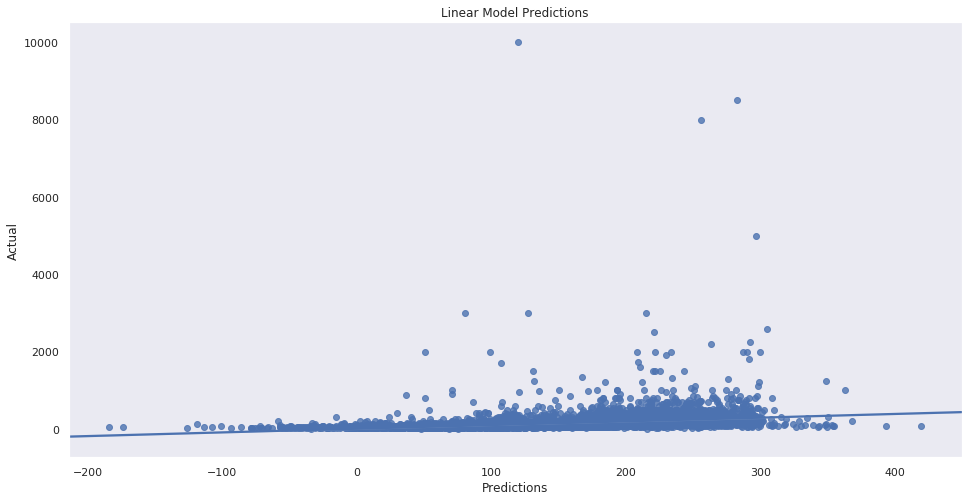

In [17]:
plt.figure(figsize=(16,8))
sns.regplot(predicts,y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Linear Model Predictions")
plt.grid(False)
plt.show()

We notice some large outliers in the positive direction. These represent listings that were much more expensive than expected. Perhaps this is an indication that they're a ripoff! Or there are more features that account for their price, such as room quality and amenities.

We notice our regressor is relatively conservative in predicting price (it doesn't go above 400), when there are listings in the thousands. We also notice it predicts negative prices for some listings, which is nonsensical.

Things to do:

* Interpret the model, and what features have the most explanatory power
* Try a more complex model (Gradient Boosted Regressor)
* Try adding text as a feature (BoW,TF-IDF)
* Individually examine regressor outliers, both high and low. Can we find ripoffs or bargains?
* Normalize the data.


## Summary